In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
import cv2

image = cv2.imread('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/mild_119.jpg')

In [3]:
image_shape = image.shape
print(image_shape)

(128, 128, 3)


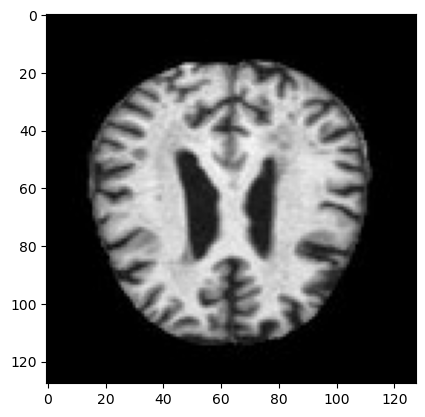

In [4]:
plt.imshow(image)

In [5]:
import glob
import librosa

mild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Mild_Demented/*.jpg')
moderate = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/*.jpg')
non = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/*.jpg')
verymild = glob.glob('/kaggle/input/alzheimer-mri-dataset/Dataset/Very_Mild_Demented/*.jpg')

data = []
labels = []

#image_size = (32,32)

for i in mild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(0)
    
for i in moderate:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(1)

for i in non:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(2)

for i in verymild:   
    image = cv2.imread(i)
    #image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(3)

    
x=np.array(data)
y=np.array(labels)
print(f'Dataset Shape: {x.shape}, Labels Shape: {y.shape}')

Dataset Shape: (6400, 128, 128, 3), Labels Shape: (6400,)


In [6]:
from sklearn.model_selection import train_test_split

# Perform train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Perform train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the input shape
input_shape = x_train[0].shape

# Define the input tensor
inputs = Input(shape=input_shape)

# First Convolutional Block
x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(inputs)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
# Residual Block
residue = x


filters = 64
kernel_size = 3
steps = 1
# ResNet 34 Layers
block_repeats = (3, 4, 6, 3)

# Generalized Loop for Repetative Blocks
for i in block_repeats:
    for j in range(i):
        x = Conv2D(filters, kernel_size, strides=steps, padding='same', activation='relu')(x)
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = Add()([x, residue])
        x = Activation('relu')(x)
        residue = x
        steps=1
        
    filters=filters*2
    steps=2
    residue = Conv2D(filters, 1, strides=steps, padding='same', activation='relu')(x)

# Average Pooling
x = GlobalAveragePooling2D()(x)

# Output layer fully connected
outputs = Dense(1000, activation='softmax')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['max_pooling2d[0][0]']      

In [8]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="ResNet34_02.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=1200,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

In [9]:
from sklearn.utils import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Class weight setting for imbalanced dataset
#class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
#class_weights = dict(zip(np.unique(y_train), class_weights))

# Define the learning rate reduction callback
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss for learning rate reduction
    factor=0.5,            # Reduce learning rate by a factor
    patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Minimum learning rate
)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('ResNet34_best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 40
batch_size = 128
history = model.fit(x_train, y_train, 
                  validation_data=(x_val,y_val), 
                  #class_weight=class_weights, 
                  epochs=epochs, 
                  batch_size=batch_size,
                  callbacks=[lr_callback,checkpoint_callback,early_stopping_callback])

# Evaluate the model
ResNet34_best_model = tf.keras.models.load_model('ResNet34_best_model.h5')
loss, accuracy = ResNet34_best_model.evaluate(x_test, y_test)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

# Make predictions on new images
predictions = ResNet34_best_model.predict(x_test[:10])
predicted_classes = np.argmax(predictions, axis=1)

# Print the predicted class and corresponding true class
for i in range(len(predicted_classes)):
    print(f"Predicted class: {predicted_classes[i]}, True class: {np.argmax(y_test[i])}")

Epoch 1/40
32/32 [==============================] - 26s 146ms/step - loss: 54.6365 - accuracy: 0.3501 - val_loss: 4.4078 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 2/40
32/32 [==============================] - 4s 133ms/step - loss: 2.1617 - accuracy: 0.3745 - val_loss: 1.0580 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 3/40
32/32 [==============================] - 4s 132ms/step - loss: 1.0500 - accuracy: 0.4963 - val_loss: 1.0308 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 4/40
32/32 [==============================] - 4s 133ms/step - loss: 1.0404 - accuracy: 0.4963 - val_loss: 1.0147 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 5/40
32/32 [==============================] - 4s 134ms/step - loss: 1.0385 - accuracy: 0.4963 - val_loss: 1.0103 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 6/40
32/32 [==============================] - 4s 133ms/step - loss: 1.0357 - accuracy: 0.4963 - val_loss: 1.0082 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 7/40
32/32 [==============================] - 4s 131ms/step - 

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = ResNet34_best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
class_names = list(['mild','moderate','non','verymild'])
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

40/40 [==============================] - 0s 11ms/step
Classification Report:
               precision    recall  f1-score   support

        mild       0.88      0.89      0.88       201
    moderate       0.75      1.00      0.86         6
         non       0.97      0.92      0.94       643
    verymild       0.86      0.90      0.88       430

    accuracy                           0.91      1280
   macro avg       0.86      0.93      0.89      1280
weighted avg       0.91      0.91      0.91      1280



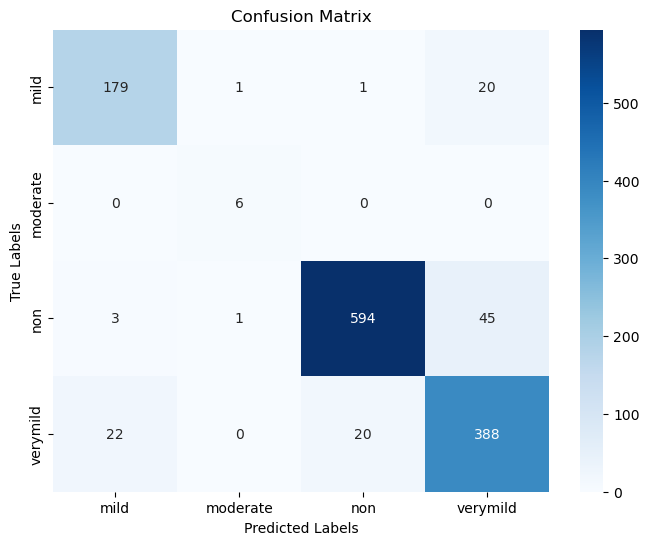

In [11]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

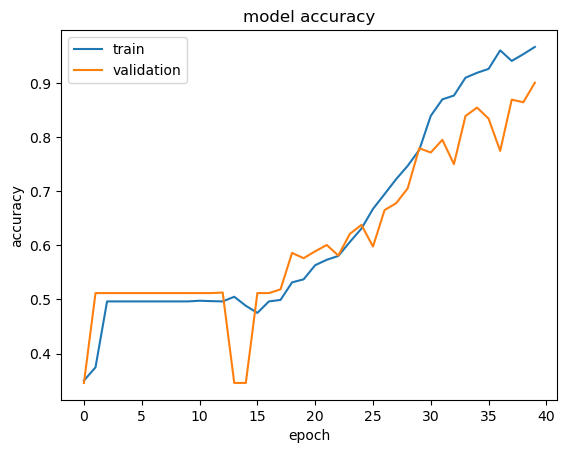

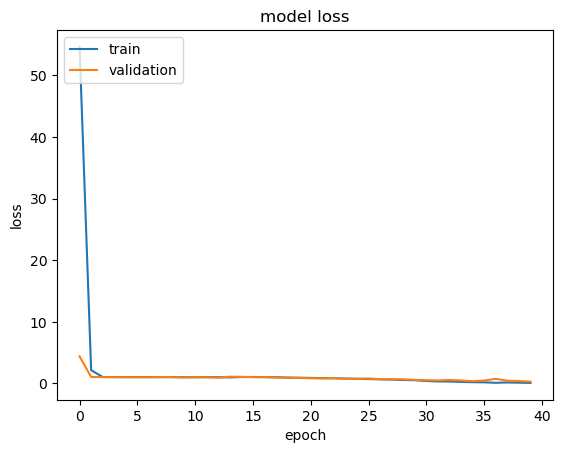

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()